# Importación de librerías

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from src.video_processing_functions import *

# Experimentos para el algoritmo *Frequency Domain Image Blur Measure* (FM)

## Medición sobre todo el frame

A continuación se presenta un experimento para medir el tiempo de ejecución del algoritmo FM sobre todo el frame. Utilizaremos el video [focus_video.mov](resources/focus_video.mov) para la experimentación. 

La función `calculate_video_quality` recibe el path del video y retorna una lista con los valores de calidad de cada frame.  También abre una ventana mostrando el video.

In [2]:
# Define the path to the video
video_path = 'resources/focus_video.mov'

In [3]:
# Calculate the quality measurements of the video
quality_measurements = calculate_video_quality(video_path)

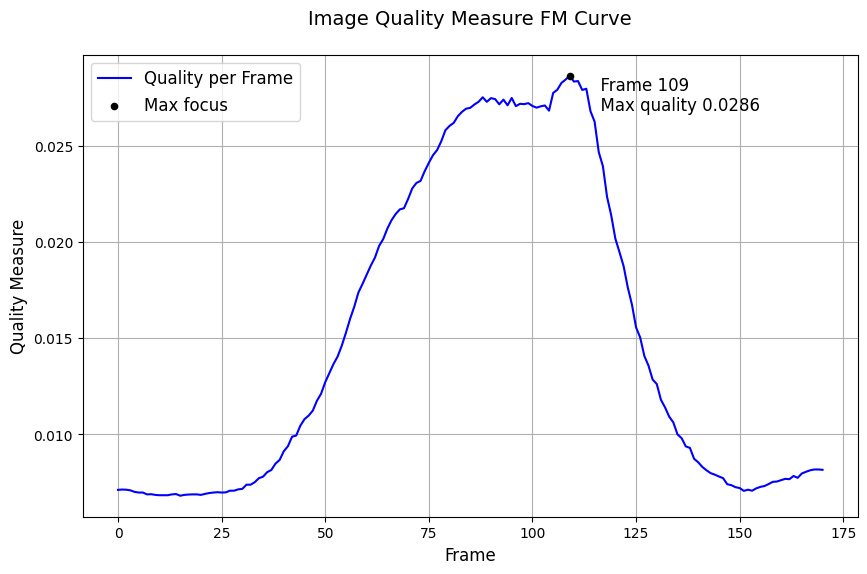

In [4]:
# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.002, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

Como se puede ver en la gráfica superior, la calidad de la imagen es variable a lo largo del video. La calidad empieza a subir a partir del frame 30, logra estabilizarse entre los frames 80 y 100, luego alcanza un **punto de máxima calidad de 0.0286 en el frame 109**, posteriormente disminuye.

## Medición sobre una ROI ubicada en el centro de la imagen

Área de la ROI de 5 o 10% del tamaño de la imagen original.

In [3]:
# Calculate the quality measurements of the video with a ROI
roi_percentage = 0.05
quality_measurements_roi = calculate_video_quality(video_path, roi_percentage=roi_percentage)

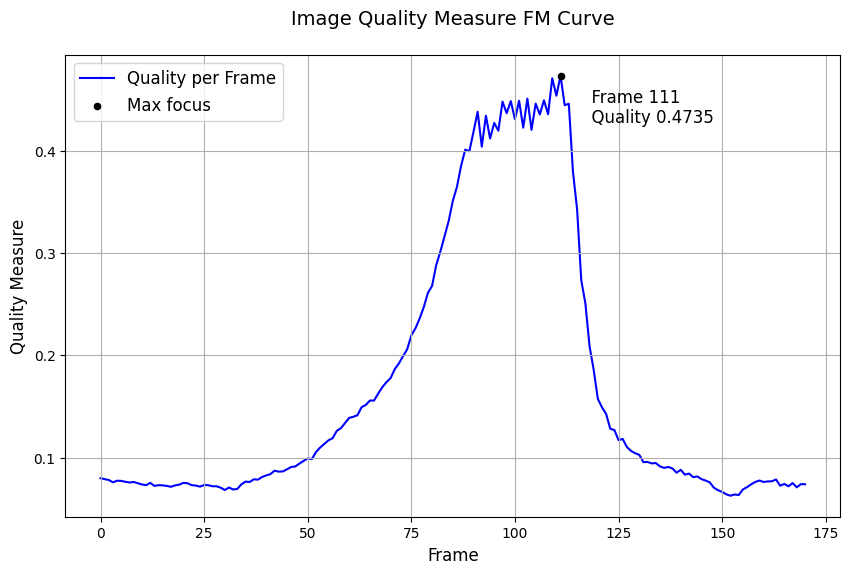

In [4]:
# Find the max focus value and its index
max_focus_index = quality_measurements_roi.index(max(quality_measurements_roi))
max_focus_value = round(max(quality_measurements_roi), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_roi, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

## Medición sobre una matriz de enfoque

In [81]:
def calculate_video_quality_on_grid(video_path: str, N: int, M: int, roi_percentage: float, delay: int = 42) -> list:
    """
    Calculates the quality measure for each frame in the video over a NxM grid of equispaced rectangular elements within a central ROI.
    
    Parameters:
    video_path (str): The path to the video file.
    N (int): Number of rows in the grid.
    M (int): Number of columns in the grid.
    roi_percentage (float): Percentage of the frame area to be used as the ROI.
    delay (int): The delay between frames in milliseconds.
    
    Returns:
    list: A list of average quality measures for each frame over the specified grid within the ROI.
    """
    # Create a video capture object
    cap = cv.VideoCapture(video_path)
    # Check if the video is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []
    
    # Initialize the quality measure list
    quality_measure_list = []

    while True:
        # Capture the current frame
        ret, frame = cap.read()
        # Check if the frame is captured successfully
        if not ret:
            break
        
        # Frame dimensions
        height, width = frame.shape[:2]
        
        # Calculate the dimensions of the ROI
        roi_height = int(height * np.sqrt(roi_percentage))
        roi_width = int(width * np.sqrt(roi_percentage))
        
        # Calculate the starting point of the ROI
        start_y = (height - roi_height) // 2
        start_x = (width - roi_width) // 2
        
        # Calculate dimensions for each grid element (smaller squares) and spacing
        square_height = roi_height // (N + (N + 1))
        square_width = roi_width // (M + (M + 1))
        vertical_spacing = (roi_height - (N * square_height)) // (N + 1)
        horizontal_spacing = (roi_width - (M * square_width)) // (M + 1)
        
        # Initialize a list to store quality measures for the current frame
        frame_quality_measures = []
        
        for i in range(N):
            for j in range(M):
                # Calculate the start and end points for the current square element within the ROI
                elem_start_x = start_x + horizontal_spacing * (j + 1) + j * square_width
                elem_end_x = elem_start_x + square_width
                elem_start_y = start_y + vertical_spacing * (i + 1) + i * square_height
                elem_end_y = elem_start_y + square_height
                
                # Crop the current square element from the frame
                grid_element = frame[elem_start_y:elem_end_y, elem_start_x:elem_end_x]
                
                # Convert the grid element to grayscale
                gray_element = cv.cvtColor(grid_element, cv.COLOR_BGR2GRAY)
                
                # Compute the quality measure for the grid element
                fm = frequency_domain_blur_measure(gray_element)
                
                # Save the fm value to the frame's quality measure list
                frame_quality_measures.append(fm)
                
                # Draw the square on the frame for visualization
                cv.rectangle(frame, (elem_start_x, elem_start_y), (elem_end_x, elem_end_y), (0, 255, 0), 1)
        
        # Calculate the average quality measure for the frame
        average_quality = np.mean(frame_quality_measures)
        quality_measure_list.append(average_quality)
        
        # Show the video frame with squares for visualization
        cv.imshow('Frame with Grid', frame)
        
        # Break the loop when 'q' is pressed or wait for the delay
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break
    
    # Release the capture
    cap.release()
    # Destroy all the windows
    cv.destroyAllWindows()
    
    return quality_measure_list

In [82]:
quality_3x3_5_percent = calculate_video_quality_on_grid(video_path, 3, 3, 0.05)


In [83]:
quality_7x5_10_percent = calculate_video_quality_on_grid(video_path, 7, 5, 0.10)


In [84]:
quality_10x10_5_percent = calculate_video_quality_on_grid(video_path, 10, 10, 0.05)